# For log returns

In [1]:
# import sympy
# sp = sympy
import numpy as np
from scipy.integrate import odeint,RK45,solve_ivp
import matplotlib.pyplot as plt

# Functions to Derive Affine Form

In [2]:
def get_g(a,b,c):
    return np.sqrt(b**2 - 4.0*a*c)
    
def get_Riccati_solution(a,b,c,tau,f0):
    g = get_g(a,b,c)
    ex = np.exp(g*tau) - 1
    num = 2*g*f0 + ((b+g)*f0+2*c)*ex
    denom = 2*g - (2*a*f0+b-g)*ex
    return num/denom

def get_Riccati_solution_vec(a,b,c,tau,f0):
    n = len(a)
    res = np.zeros(n)
    for i in range(n):
        res[i] = get_Riccati_solution(a[i],b[i],c[i],tau,f0[i])
    return res

def get_int_Riccati_solution(a,b,c,tau,riccati_f0):
    g = get_g(a,b,c)
    ex = np.exp(g*tau) - 1
    term1 = (-b+g)*tau/(2.0*a) 
    term2 = np.log(2*g/np.abs(2*g+(g-b-2*a*riccati_f0)*ex))/a
#     term2 = sp.log(2*g/sp.Abs(2*g+(g-b-2*a*riccati_f0)*ex))/a
    return term1 + term2

def get_int_Riccati_solution_vec(a,b,c,tau,riccati_f0):
    n = len(a)
    res = np.zeros(n)
    for i in range(n):
        res[i] = get_int_Riccati_solution(a[i],b[i],c[i],tau,riccati_f0[i])
    return res

def get_E_vAvB(t,alp,beta,sigma,v0):
    res = np.exp(-beta*t)*(v0 - alp/beta) + alp/beta
    return res.prod()

def get_int_E_vAvB(t,alpha,beta,sigma,v0):
    """
    Vectorized implementation
    """
    res = -(v0-alpha/beta).prod()*(np.exp(-beta.prod()*t)-1)/beta.sum() - np.sum((v0-alpha/beta)*np.flip(alpha)/beta.prod()*(np.exp(-beta*t)-1)) + alpha.prod()/beta.prod()*t
    return res

def get_CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return sample

# Input Parameters

In [3]:
# correlation parameters
sAsB = 0.015 # It is important. It impacts
sAsB = 0.5 # It is important. It impacts
sAvA = -0.5
sAvB = -0.5
sBvA = -0.5
sBvB = -0.5
vAvB = 0.5
# sA, sB, vA, vB check the sequense always
correlation = np.matrix([[1,sAsB,sAvA,sAvB],
                         [sAsB,1,sBvA,sBvB],
                         [sAvA,sBvA,1,vAvB],
                         [sAvB,sBvB,vAvB,1]])
# correlation = np.matrix([[1,sAvA,sAsB,sAvB],
#                          [sAvA,1,vAsB,vAvB],
#                          [sAsB,vAsB,1,sBvB],
#                          [sAvB,vAvB,sBvB,1]])
if np.sum(np.linalg.eigvals(correlation) < 0):
    print('Correlation matrix is not positive definite!')
L = np.linalg.cholesky(correlation) # Cholesky decomposition of the correlation for simulation

params = {
# chf params    
    'tau': 1, # investment time
    'h': 29, # horizon in the future
    'w': np.array([1,1,1]), # weights for chf
    'u': np.array([1.0,1.0]), # weights for price
    'psi': np.array([1.0,1.0]), # weights for vol
# treasury params
    'l0': -0.127061, # constant shift
    've': np.array([0.2715618,0.0195524,0.0009720]),
    'ka': np.array([5.6772530,0.2520333,0.147]),
    'si': np.array([0.0181427,0.0422960,0.034]), # adjusted si[2]
    'x0': np.array([0.05095958,0.06725220,0.00961570]),
# Equity parameters (US LC, OS)
    's0': np.array([0.0,0.0]), # initial value
    'mu0': np.array([0.000815,0.000822]), # official value
    'mu0': np.array([0.07,0.110]), # my value
    'mu1': np.array([-0.5,-0.5]), # I think just -0.5 is too strict? High volatility -> Always stock crush
    # mu1 = np.array([-0.001,-0.002]) + np.array([-0.5,-0.5]) # I think just -0.5 is too strict?
    'v0': np.array([0.019528084,0.080837794]),
    'alpha': np.array([0.022,0.108045]),
    'beta': np.array([0.98803,1.284485]),
    'sigma': np.array([0.142303,0.121922]), # volatility of variance
    'correlation': correlation,
    'L': L
}
params["th"] = params["ve"]/params["ka"]

In [4]:
def get_chf(params):
    # compute chf
    p = params
    u = p["u"]
    tau = p["tau"]
    correlation = p["correlation"]
    sAsB = p["correlation"][0,1]
    sBvA = p["correlation"][1,2]
    sAvB = p["correlation"][0,3]
    sigma = p["sigma"]
    # compute parameters for the affine form
    B_a = 0.5*p['si']**2
    B_b = -p['ka']
    B_c = p['u'].sum() * np.ones(len(p['x0']))
    B_f0 = p['w']
    C_a = 0.5*sigma**2
    C_b = p['u']*np.array([p['correlation'][0,3],p['correlation'][1,3]])*p['sigma']-p['beta']
    C_c = 0.5*p['u']**2 + p['u']*p['mu1']
    C_f0 = p['psi']
    E_vAvB = get_E_vAvB(30.0,p["alpha"],p["beta"],p["sigma"],p["v0"]) # presume
#     E_vAvB = get_int_E_vAvB(tau,p["alpha"],p["beta"],p["sigma"],p["v0"])
#     print(E_vAvB)

    # compute A
    A = 0.0
    A += ((u*p["mu0"]).sum() + p["l0"]*u.sum()+E_vAvB*u.prod()*sAsB)*tau # v1
#     A += ((u*p["mu0"]).sum() + p["l0"]*u.sum())*tau +E_vAvB*u.prod()*sAsB # v2
    A += (p["ka"]*p["th"]*get_int_Riccati_solution_vec(B_a,B_b,B_c,tau,B_f0)).sum()
    A += ((p["alpha"] + np.array([u[1]*sBvA,u[0]*sAvB])*sigma*E_vAvB)*get_int_Riccati_solution_vec(C_a,C_b,C_c,tau,C_f0)).sum()
    # compute B
    B =  get_Riccati_solution_vec(B_a,B_b,B_c,tau,B_f0)
    # compute C
    C = get_Riccati_solution_vec(C_a,C_b,C_c,tau,C_f0)
    # Compute ChF
    return np.exp(A + np.dot(u,p["s0"]) + np.dot(B,p["x0"]) + np.dot(C,p["v0"])),A,B,C # return A, B, C in case it is necessary

In [5]:
def get_return_chf(params):
    # Now compute A2, B2, C2
    _,A,B,C=get_chf(params)
    keys = ['u','w','psi','tau']
    lst = []
    for k in keys:
        lst.append(params[k])
    params['u'] = np.zeros(len(params['s0']))
    params['w'] = B
    params['psi'] = C
    params['tau'] = params['h'] # set different tau for the second affine form
    chf_ret,A2,B2,C2 = get_chf(params)
    chf_ret *= np.exp(A)
    for ind,k in enumerate(keys): # restore values
        params[k] = lst[ind]    
    return chf_ret,A,B,C,A2,B2,C2

# Monte Carlo Simulation

In [6]:
# input parameters
p = params
T = p["h"] + p["tau"]
x0 = p["x0"]
l0 = p["l0"]
ka = p["ka"]
si = p["si"]
th = p["th"]
s0 = p["s0"]
mu0 = p["mu0"]
mu1 = p["mu1"]
v0 = p["v0"]
alpha = p["alpha"]
beta = p["beta"]
sigma = p["sigma"]
L = p["L"]

# simulation parameters
np.random.seed(1)
num_steps = int(T*500)
num_paths = 10000
res = np.zeros((num_steps, num_paths))
dt = T/num_steps
t_sim = np.linspace(0.0,T,num_steps+1)
# Initialize states

x = np.zeros([num_steps+1, len(x0), num_paths]) # middle: num state var
r = np.zeros([num_steps+1, num_paths])
s = np.zeros([num_steps+1, len(s0), num_paths])
v = np.zeros([num_steps+1, len(v0), num_paths])

# Initialization
r[0,:] = l0
for j in range(len(x0)):
    x[0,j,:] = x0[j]
    r[0,:] += x0[j]
for j in range(len(s0)):
    s[0,j,:] = s0[j]
    v[0,j,:] = v0[j]
    
for i in range(num_steps):
    # noncentral chisquare processes
    # Treasury
    r[i+1,:] = l0
    for j in range(len(x0)): # x1,x2,x3
        x[i+1,j,:] = get_CIR_Sample(num_paths,ka[j],si[j],th[j],0,dt,x[i,j,:])
        r[i+1,:] += x[i+1,j,:]

    # Volatility
    dW_indep = np.random.normal(0.0,1.0,(4,num_paths))
    dW_indep = (dW_indep-dW_indep.mean(axis=1).reshape(-1,1))/dW_indep.std(axis=1).reshape(-1,1) # normalize
    # normalize 
    dW = L*dW_indep*np.sqrt(dt) # each row (sA sB vA vB)
    for j in range(len(v0)): # j in (A,B)
        drift_term = (alpha[j] - beta[j]*v[i,j,:])*dt
        dWv = dW[2+j,:] # A or B
        vol_term = sigma[j]*np.multiply(np.sqrt(v[i,j,:]),dWv)
        vol_term += 0.25*sigma[j]**2.0 * (np.power(dWv,2) - dt) # Milstein term
        v[i+1,j,:] = np.maximum(0.0,v[i,j,:] + drift_term + vol_term) # truncation
#         v[i+1,j,:] = np.abs(v[i,j,:] + drift_term*dt + vol_term ) # reflection
    
    # Stock price
    for j in range(len(s0)): # j in (A,B)
        drift_term = (np.add(r[i], mu0[j]) + mu1[j]*v[i,j,:])*dt
        dWs = dW[j,:] # A or B
        vol_term = np.multiply(np.sqrt(v[i,j,:]), dWs)
        s[i+1,j,:] = s[i,j,:] + drift_term + vol_term
    

In [7]:
h_step = int(num_steps*params["h"]/T)
h_tau_step = int(num_steps*(params["h"]+params["tau"])/T)

In [8]:
mc_du = (s[h_tau_step,:,:]-s[h_step,:,:]).mean(axis=1)
mc_duAuB = (s[h_tau_step,:,:]-s[h_step,:,:]).prod(axis=0).mean()
mc_corr = mc_duAuB - mc_du.prod()
mc_corr

0.022043070273153477

# Characteristic Function from MC

In [9]:
u = params["u"]
psi = params["psi"]
w = params["w"]
chf = np.mean(np.exp(np.dot(u,s[-1,:,:]) + np.dot(psi,v[-1,:,:]) + np.dot(w,x[-1,:,:])))
print(chf)

711.2838647170199


In [10]:
chf_MC = np.zeros(len(t_sim))
chf_analytic = np.zeros(len(t_sim))
p = params.copy()
print(u,psi,w)
for i,t_step in enumerate(t_sim):
    chf_MC[i] = np.mean(np.exp(np.dot(u,s[i,:,:]) + np.dot(psi,v[i,:,:]) + np.dot(w,x[i,:,:])))
    p['tau'] = t_step
    chf_analytic[i],_,_,_ = get_chf(p)

[1. 1.] [1. 1.] [1 1 1]


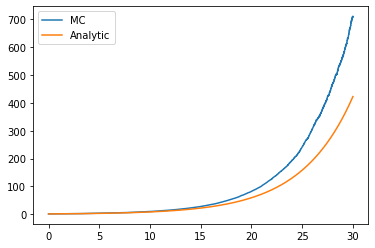

In [11]:
plt.plot(t_sim,chf_MC,label='MC')
plt.plot(t_sim,chf_analytic,label='Analytic')
plt.legend()

In [12]:
from scipy.stats import skew,kurtosis
p = params
tau = p["tau"]
x0 = p["x0"]
l0 = p["l0"]
ka = p["ka"]
si = p["si"]
th = p["th"]
s0 = p["s0"]
mu0 = p["mu0"]
mu1 = p["mu1"]
v0 = p["v0"]
alpha = p["alpha"]
beta = p["beta"]
sigma = p["sigma"]
L = p["L"]
# simulation result check
print('IR mean sim: ',r[-1,:].mean(),' steady-state ',th.sum()+l0)
print('s statistics')
print('mean of s ', s[-1,:,:].mean(axis=1))
print('var of s ', s[-1,:,:].var(axis=1))
print('skew of s ', skew(s[-1,:,:],axis=1))
print('kurtosis of s ', kurtosis(s[-1,:,:],axis=1))
print('x statistics')
print('mean of x ', x[-1,:,:].mean(axis=1))
print('var of x ', x[-1,:,:].var(axis=1))
print('skew of x ', skew(x[-1,:,:],axis=1))
print('kurtosis of x ', kurtosis(x[-1,:,:],axis=1))
print('v statistics')
print('mean of v ', v[-1,:,:].mean(axis=1))
print('var of v ', v[-1,:,:].var(axis=1))
print('skew of v ', skew(v[-1,:,:],axis=1))
print('kurtosis of v ', kurtosis(v[-1,:,:],axis=1))

print('x ss ',th)
print('Ex sim ',x[-1,0,:].mean(), x[-1,1,:].mean(), x[-1,2,:].mean())
print('v ss ',alpha/beta)
print('Ev sim ',v[-1,0,:].mean(), v[-1,1,:].mean())
v_exact0 = get_CIR_Sample(num_paths,beta[0],sigma[0],(alpha/beta)[0],0.0,tau,v0[0])
v_exact1 = get_CIR_Sample(num_paths,beta[1],sigma[1],(alpha/beta)[1],0.0,tau,v0[1])
print('v exact ',v_exact0.mean(),' ',v_exact1.mean())

IR mean sim:  0.005377316531987319  steady-state  0.0049631918489159155
s statistics
mean of s  [1.89706493 2.16733108]
var of s  [0.78010777 2.65320712]
skew of s  [-0.27725778 -0.08980224]
kurtosis of s  [0.23036862 0.00428682]
x statistics
mean of x  [0.04783939 0.07794529 0.00665363]
var of x  [1.36067062e-06 2.80620776e-04 2.61103122e-05]
skew of x  [0.04674415 0.4214312  1.48070911]
kurtosis of x  [-0.05846405  0.2763226   3.21734188]
v statistics
mean of v  [0.02229829 0.08413628]
var of v  [0.00023145 0.00048915]
skew of v  [1.36500303 0.4907614 ]
kurtosis of v  [2.78758999 0.22820358]
x ss  [0.04783331 0.07757864 0.00661224]
Ex sim  0.0478393938266434 0.07794528874065133 0.006653633964692577
v ss  [0.02226653 0.08411542]
Ev sim  0.022298294998730445 0.08413627825865197
v exact  0.021445468553363257   0.08314167090733969
